### **Connective Field Modeling: Object-Oriented Programming Version**

Connective Field Modeling is a computational technique used to characterize the relationship between neuronal populations across different regions of the brain. It models how sensory inputs, represented in one visual area, are transformed and projected to another visual area.

---

#### **Connective Field Modeling Parameters**

1. **<span style="color: black;">Sigma</span>**  
   <small>- The spread or size of the connective field.</small>  
   <small>- Represents the spatial extent of influence from the source region.</small>

2. **<span style="color: black;">Eccentricity</span>**  
   <small>- The radial distance of the center of the connective field from the origin of the visual field representation.</small>

3. **<span style="color: black;">Polar Angle</span>**  
   <small>- The angular position of the connective field in visual space.</small>

4. **<span style="color: black;">Variance Explained</span>**  
   <small>- A measure of how well the modeled time series fits the observed data.</small>  
   <small>- Indicates the quality of the connective field fit for each voxel.</small>

5. **<span style="color: black;">Predicted Time Series</span>**  
   <small>- The estimated BOLD signal for each voxel in the target area.</small>  
   <small>- Derived from the best-fit connective field model.</small>

---

#### **Process for Obtaining Connective Field Parameters**

1. **<span style="color: black;">Define Source and Target Areas</span>**  
   <small>- Extract vertices or voxels belonging to these areas.</small>  
   <small>- Use label files or predefined masks to identify regions of interest.</small>

2. **<span style="color: black;">Compute Geodesic Distances</span>**  
   <small>- Compute the true distances on the cortical surface between the vertices in the source area.</small>  

3. **<span style="color: black;">Random Initialization</span>**  
   <small>- Choose an initial random vertex from the source area as a starting point for the connective field center. </small>
   <small>-Set initial parameters to random or default values.</small>

4. **<span style="color: black;">Iterative Optimization</span>**  
   <small>- For each voxel in the target area define a Gaussian function centered at the current connective filed locatin in the source area. </small>
   <small>- Predict the BOLD signal for the target voxel by combining the source time series with the spatial weighting function. </small>
   <small>- Adjust parameters to maximize the fit using a least-squares or gradient-based optimization. </small>

5. **<span style="color: black;">Evaluate Model Fit</span>**  
   <small>- Calculate the variance explained (R²) for the modeled time series compared to the observed time series.</small>  
   <small>- Keep the parameters that provide the best fit for each voxel.</small> 


NEXT MEETING Monday 10th February
1. Store the eccentricity and polar angle.  
2. Fix the Monte Carlo Markov Chain Errors.

In [1]:
# Export the required libraries 
import os
import time 
import math as m 
import pandas as pd
import random 
import cortex
import numpy as np
import scipy.optimize
import matplotlib.pyplot as plt

In [2]:
class Vertex:
    """ The Vertex class is designed to represent a single vertex from a label file generated by FreeSurfer. 
    It stores details about the vertex such as:
    --- Index: A unique identifier for the vertex.
    --- Coordinates: The 3D spatial location (x, y, z) of the vertex.
    --- Visual Area: The functional area of the brain to which the vertex belongs.
    Additionally, the class provides a static method, load_vertices, which reads a label file and creates a 
    list of Vertex objects for a specified visual area, with an option to load only one vertex.""" 
        
    def __init__(self, index: int, x: float, y: float, z: float, visual_area: int):
        self.index = index                   # e.g. 14017 
        self.x = x                           # e.g. -10.072  
        self.y = y                           # e.g. -78.545
        self.z = z                           # e.g. 66.078 
        self.visual_area = visual_area       # e.g. 1

    def load_vertices(labels_path: str, visual_area: int, load_one=False):
        """
        Load vertices from the label file for a given visual area.
            Inputs: 
            --- Label: the path to the label file to load the vertices from.
            --- Visual Area: 1 for source area, 2 for target area
            --- Load One: if true, load only one vertex.
            Outputs:
            --- Vertex: a list of vertices objects loaded from the label file.
        """
        # Read the label file into a DataFrame 
        df = pd.read_csv(labels_path, header=None, skiprows=2, sep='\\s+') 
        # Filter the rows where the value in column 4 matched the value of visual area
        df_filtered = df[df[4] == visual_area]

        # Convert the filtered rows into a vertex object 
        # This expression takes filtered rows from the DataFrame, interprets each row as a set of 
        # arguments for the Vertex constructor, and builds a NumPy array of Vertex objects
        vertices = np.array([Vertex(*i) for i in df_filtered.itertuples(index=False)])
        if load_one:
            vertex = vertices[0]
            print(f"Loaded one Vertex: Index = {vertex.index}, X = {vertex.x}, Y = {vertex.y}, Z = {vertex.z}, Visual Area = {vertex.visual_area}")
            return [vertex]
            
        # Print how many vertices were loaded for the specific visual area
        print(f"Loaded {len(vertices)} vertices from Visual Area {visual_area} from {labels_path}.")
        
        return vertices

In [3]:
def surfs(subject: str, hemi:str):
    """
    Load the cortical surface for a given subject and hemisphere.
    Specifies whether the surface is from the left ("lh") or right ("rh") hemisphere.
    Returns the cortical surface object for the specified hemisphere.
    """
    if hemi == "lh":
        surf_data = cortex.db.get_surf(subject, "fiducial")[0]  # Left hemisphere
    elif hemi == "rh":
        surf_data = cortex.db.get_surf(subject, "fiducial")[1]  # Right hemisphere
        
    surface = cortex.polyutils.Surface(*surf_data)
    return surface

In [4]:
class Distances(Vertex):
    """ 
    The Distances class computes the geodesic distance matrix for a set of vertices,
    saving it as a CSV file for later use, and provides basic inspection of the results.
    """

    def __init__(self, subject, hemi, matrix_dir, csv_path):
        self.subject = subject
        self.hemi = hemi
        self.matrix_dir = matrix_dir
        self.csv_path = csv_path

    def geodesic_dists(self, hemi, subject, vertices, source, output_dir):
        """
        Compute geodesic distances between source vertices and save the result to a CSV file.
        """
        # Extract source vertex indices
        source_verts = np.array([v.index for v in vertices])

        # Determine the output file path based on hemisphere and source
        output_path = f"{output_dir}/{subject}_distance_{hemi}_{source}.csv"

        # Try loading the distance matrix from a CSV file
        if os.path.exists(output_path):
            try:
                distance_matrix = pd.read_csv(output_path, index_col=0).values
                print(f"Loaded distance matrix with shape: {distance_matrix.shape}")
                return distance_matrix
            except Exception as e:
                print("⚡ Proceeding to compute the geodesic distance matrix...")
        
        # Load the cortical surface for the given hemisphere
        surface = surfs(subject, hemi)
        
        # Initialize the distance matrix
        dists_source = np.zeros((len(source_verts), len(source_verts)), dtype=np.float32)
    
        # Compute geodesic distances for each source vertex
        for i in range(len(source_verts)):
            dists = surface.geodesic_distance(source_verts[i] - len(vertices))
            for j in range(len(source_verts)):
                dists_source[i, j] = dists[source_verts[j] - len(vertices)]
        
        # Convert the distance matrix to a DataFrame for saving as CSV
        distance_df = pd.DataFrame(dists_source, index=source_verts, columns=source_verts)
        distance_df.to_csv(output_path)
        
        # Print shape and first 4 rows and columns for verification
        print(f"Distance matrix saved with shape: {distance_df.shape}")

        # Return the computed distance matrix
        return dists_source

In [5]:
class TimeCourse:
    """ 
    Loading, processing, and analyzing time course data for single or multiple vertices.
    """

    def __init__(self, time_course_file: str, vertices: list[Vertex], cutoff_volumes: int):
        self.vertices = vertices  # List of Vertex objects
        self.cutoff_volumes = cutoff_volumes
        self.data = np.load(time_course_file)  # Load time course data
        self.tSeries = self.load_time_courses()

    def load_time_courses(self) -> dict:
        duration = self.data.shape[0]
        tSeries = {}
        # Iterates over the self.vertices list, accessing the index of each vertex.
        for vertex in self.vertices:
            index = vertex.index
            # Extracts the time course for each vertex
            time_course = self.data[self.cutoff_volumes:duration, index]
            # Stores the time course in a dictionary using the vertex index as the key.
            tSeries[index] = time_course

        # Print details about the tSeries dictionary
        return tSeries

    def z_score(self) -> dict:
        # Performs z-scoring (standardization) of the time course data for each vertex.
        z_scored_data = {}
        # Computes the z-score for each time course
        for index, time_course in self.tSeries.items():
            # Subtracts the mean and divides by the standard deviation.
            z_scored_data[index] = (time_course - np.mean(time_course)) / np.std(time_course)
        return z_scored_data

    def plot_time_series(self, vertex_index: int, show: bool = True) -> None:
        if vertex_index not in self.tSeries:
            print(f"Vertex {vertex_index} not found in the time series data.")
            return

        time_course = self.tSeries[vertex_index]
        plt.figure(figsize=(10, 5))
        plt.plot(time_course, label=f'Vertex Index: {vertex_index}', color='blue')
        plt.title(f'Time Series for Vertex {vertex_index}')
        plt.xlabel('Time (Volumes) after Cutoff')
        plt.ylabel('BOLD Signal')
        plt.legend()
        plt.grid()
        if show:
            plt.show()
        
    def plot_comparison(self, z_scored_data: dict, vertex_index: int, title_prefix: str, show: bool = True) -> None:
        """
        Plot the original and z-scored time series for a specific vertex.
        """
        original_time_course = self.tSeries[vertex_index]
        z_scored_time_course = z_scored_data[vertex_index]
        plt.figure(figsize=(12, 6))
        plt.plot(original_time_course, label="Original Time Series", linestyle="-", marker="o", alpha=0.7)
        plt.plot(z_scored_time_course, label="Z-Scored Time Series", linestyle="--", marker="x", alpha=0.7)
        plt.title(f"{title_prefix} Vertex {vertex_index} - Before and After Z-Scoring")
        plt.xlabel("Time Points")
        plt.ylabel("BOLD Signal")
        plt.legend()
        plt.grid()
        if show:
            plt.show()

In [6]:
class ConnectiveField:
    """Connective Field class to calculate sigma, eccentricity, variance explained, polar angle, and predicted time course for a voxel."""

    def __init__(self, center_vertex: Vertex, vertex: Vertex):
        """
        Initialize the ConnectiveField class with a specific vertex.
        """
        self.vertex = vertex  # Use the vertex passed during initialization
        self.center_vertex = center_vertex  # Center of the Gaussian
        self.sigma = None  # Spread of the connective field
        self.eccentricity = None  # Distance from center (eccentricity)
        self.polar_angle = None  # Angle to indicate direction
        self.variance_explained = None  # Fit metric for model evaluation
        self.predicted_time_course = None  # Predicted BOLD signal time series
        self.observed_time_series = None  # Observed time series for the voxel
        self.best_fit = None  # Stores best optimization fit

    # Select a Vertex in the Target Area
    def select_target_vertex(self, idxTarget: list[Vertex], index: int = None) -> Vertex:
        if index is not None:
            selected_vertex_target = idxTarget[index]
            print(f"Selected Target Vertex by Index: Index = {selected_vertex_target.index}, Coordinates = ({selected_vertex_target.x}, {selected_vertex_target.y}, {selected_vertex_target.z})")
        else:
            selected_vertex_target = random.choice(idxTarget)
            print(f"Randomly Selected Target Vertex: Index = {selected_vertex_target.index}, Coordinates = ({selected_vertex_target.x}, {selected_vertex_target.y}, {selected_vertex_target.z})")
        return selected_vertex_target

    # Select a Vertex in the Source Area
    def select_source_vertex(self, idxSource: list[Vertex], index: int = None) -> Vertex:
        if index is not None:
            selected_vertex_source = idxSource[index]
            print(f"Selected Source Vertex by Index: Index = {selected_vertex_source.index}, Coordinates = ({selected_vertex_source.x}, {selected_vertex_source.y}, {selected_vertex_source.z})")
        else:
            selected_vertex_source = random.choice(idxSource)
            print(f"Randomly Selected Source Vertex: Index = {selected_vertex_source.index}, Coordinates = ({selected_vertex_source.x}, {selected_vertex_source.y}, {selected_vertex_source.z})")
        return selected_vertex_source

    # Define Range of Sizes
    def define_size_range(self, start: float = 0.01, stop: float = 10.5, num: int = 50) -> list:
        # sigma_values = np.linspace(start, stop, num).tolist()
        sigma_values = np.random.uniform(start, stop, num).tolist()
        print(f"Sigma Values for Optimization: {sigma_values}")
        return sigma_values

    # Define the Gaussian distribution
    def calculate_gaussian_weights(self, distances: np.ndarray, sigma: float) -> np.ndarray:
        """
        A Gaussian weight is computed for each source vertex based on its distance from the center vertex and the current sigma value.
        The Gaussian weights determine how much influence each source vertex has on the predicted time series.
        The closer a vertex is to the center, the higher its weight 
        """
        weights = np.exp(-np.square(distances) / (2 * sigma ** 2))  # Compute Gaussian weights
        weights_normalized = weights / np.sum(weights)  # Normalize the weights
        return weights_normalized

    # Compute the Prediction
    def compute_prediction(self, source_time_series: dict, distances: np.ndarray, sigma: float) -> np.ndarray:
        """
        Compute the predicted time series for the target vertex using vectorized operations.
        """
        # Calculate Gaussian weights
        weights = self.calculate_gaussian_weights(distances, sigma)
        # Filter the source_time_series to match the filtered distances
        filtered_vertices = list(distances.index)  
        filtered_time_series = [source_time_series[v] for v in filtered_vertices]
        # Stack the filtered time series into a 2D array
        time_series_matrix = np.stack(filtered_time_series, axis=1)  # (time_points x num_filtered_vertices)
        predicted_time_series = np.dot(time_series_matrix, weights) # Compute the weighted sum using matrix multiplication

        return predicted_time_series

    # Error Evaluation
    def evaluate_fit(self, observed: np.ndarray, predicted: np.ndarray) -> float:
        """
        Evaluate the variance explained (R²) between observed and predicted time series.
        """
        ss_total = np.sum((observed - np.mean(observed)) ** 2) # The total variance in the observed time series.
        ss_residual = np.sum((observed - predicted) ** 2) # The variance in the observed time series that isn’t explained by the predicted time series. 
        variance_explained = 1 - (ss_residual / ss_total) # The proportion of variance explained by the prediction.
        return variance_explained

    def optimize_parameters(self, observed: np.ndarray, source_time_series: dict, distance_matrix: pd.DataFrame, sigma_values: list):
        best_sigma = None 
        best_variance_explained = -np.inf 
        best_prediction = None  # The predicted time series that corresponds to the best fit.
        best_source_index = None  # Store the best source vertex index
        
        for sigma in sigma_values:  # Iterate through each value of sigma
            col_position = distance_matrix.columns.get_loc(self.center_vertex.index)  # Get column position of the center vertex
            row_data = distance_matrix.iloc[:, col_position]  # Extract distances from the center vertex
            filtered_row = row_data[row_data <= sigma]  # Filter distances less than or equal to the current sigma
            
            predicted = self.compute_prediction(source_time_series, filtered_row, sigma)  # Compute prediction
            variance_explained = self.evaluate_fit(observed, predicted)  # Compute variance explained (R²)

            # Update the best fit if variance explained improves
            if variance_explained > best_variance_explained:
                best_variance_explained = variance_explained  # Store the best R² value
                best_sigma = sigma  # Store the best sigma value
                best_prediction = predicted  # Store the best predicted time series
                best_source_index = self.center_vertex.index  # Store the best source index  

        # Store the best results
        self.sigma = best_sigma
        self.variance_explained = best_variance_explained
        self.predicted_time_course = best_prediction
        self.best_source_index = best_source_index  

    def plot_time_series(self, save_path: str = None):
        """
        Plot the observed vs. predicted time series.
        If `save_path` is provided, the plot is saved to the specified location and not displayed.
        """
        plt.figure(figsize=(12, 6))
        plt.plot(self.observed_time_series, label='Observed Time Series', linestyle='-', marker='o')
        plt.plot(self.predicted_time_course, label='Predicted Time Series', linestyle='--', marker='x')
        plt.title('Observed vs Predicted Time Series')
        plt.xlabel('Time Points')
        plt.ylabel('BOLD Signal')
        plt.legend()
        plt.grid(True)

        if save_path:
            plt.savefig(save_path)  # Save the plot to the specified path
            plt.close()  # Close the plot to free memory
        else:
            plt.show()  # Display the plot on the screen

    def iterative_fit_target(self, target_vertex: Vertex, target_time_course, source_vertices: list[Vertex], 
                            source_time_series: dict, distance_matrix: pd.DataFrame, 
                            sigma_values: list, best_fit_output: str, individual_output_dir: str, plot_dir: str):
        """
        Iterative fit for the selected target vertex:
        - Append the best fit to a best fit CSV file.
        - Save all fits for the target vertex in a separate CSV file.
        - Plot observed vs. predicted for the best fit and optionally plot all fits.
        """
        results = []  # Store all fits for this target vertex
        self.observed_time_series = target_time_course.tSeries[target_vertex.index]  # Observed time series for the target voxel

        for source_vertex in source_vertices:  # Iterate through all source vertices
            self.center_vertex = source_vertex  # Temporarily set center_vertex to the current source vertex
            self.optimize_parameters(self.observed_time_series, source_time_series, distance_matrix, sigma_values)  # Optimize for this source vertex

            # Append results for the current source vertex
            results.append({
                "Target Vertex Index": target_vertex.index,
                "Source Vertex Index":self.best_source_index, # Store the best vertex index 
                "Best Sigma": self.sigma,
                "Best Variance Explained": self.variance_explained})

        # Convert results to DataFrame
        results_df = pd.DataFrame(results)
        # Sort results by variance explained (descending)
        results_df = results_df.sort_values(by="Best Variance Explained", ascending=False)

        # Save all fits to an individual CSV file for this target vertex
        individual_file = os.path.join(individual_output_dir, f"all_fits_target_vertex_{target_vertex.index}.csv")
        results_df.to_csv(individual_file, index=False)

        # Append the best fit to the best fit CSV file
        best_fit = results_df.iloc[0]  # Best fit is the first row after sorting
        best_fit_df = pd.DataFrame([best_fit])
        best_fit_df.to_csv(best_fit_output, mode="a", index=False, header=not os.path.exists(best_fit_output))

        # Plot observed vs. predicted for the best fit
        self.center_vertex = next(v for v in source_vertices if v.index == best_fit["Source Vertex Index"])
        self.optimize_parameters(self.observed_time_series, source_time_series, distance_matrix, sigma_values)  # Re-optimize for best source vertex
        plot_file = os.path.join(plot_dir, f"best_fit_plot_target_vertex_{target_vertex.index}.png")
        os.makedirs(os.path.dirname(plot_file), exist_ok=True)  # Ensure the directory exists
        self.plot_time_series(save_path=plot_file)

        # Return both DataFrames for reference
        return results_df, best_fit_df

In [7]:
class MCMC:
    def __init__(self, idxSource, distances, tSeriesSource, tSeriesTarget, n_iter, TR, rMin, radius, betaBool, burnIn, percBurnIn, proposalWidth, lSigma, lBeta):
        # Data
        self.idxSource = idxSource
        self.distances = distances
        # self.tSeriesSource = tSeriesSource
        self.tSeriesTarget = tSeriesTarget
        self.tSeriesSource = tSeriesSource.astype(np.float32) ### It was in the original script 
        # MCMC Parameters
        self.n_iter = n_iter
        self.TR = TR
        self.rMin = rMin
        self.radius = radius
        self.betaBool = betaBool
        self.burnIn = burnIn
        self.percBurnIn = percBurnIn
        self.proposalWidth = proposalWidth
        self.lSigma = lSigma
        self.lBeta = lBeta
    
    # @jit(nopython=True)
    def normcdf(self, x: float, mu: float = 0.0, sigma: float = 1.0):
        '''
        Calculate the normal cumulative distribution function (numba compatible)
        Computes the CDF of a normal distribution using the error function
        Then it scales the resutl to produce a value between 0 and 1
        '''
        return (1.0 + m.erf((x - mu) /(sigma* np.sqrt(2.0)))) / 2.0

    # @jit(nopython=True)
    def normpdf(self, x: float, mu: float = 0.0, sigma: float = 1.0):
        '''
        Calculate probability density function (numba compatible)
        '''
        return (np.exp(-((x-mu)/(sigma))**2)/2)/(sigma*np.sqrt(2*np.pi))

    ### WHAT IS DPROP?
    def dProp(self, lStepSize, maxStep):
        return np.abs(maxStep * self.normcdf(lStepSize) - maxStep / 2)

    def centerProp(self, stProposal: float, distances: np.ndarray, centerSourceIndex: int):
        '''
        Calculate the new proposed center 
        - Computes the absolute difference between all the distances and the proposed center
        - Identifies the index where the asbolute distance is minimum and randomly selects the new center from there
        '''
        distances = distances[:, centerSourceIndex]
        absDistances = np.abs(distances - stProposal)
        minimumIndex = np.where(absDistances == np.min(absDistances))
        centerProposalIndex = np.random.choice(minimumIndex[0], 1)
        return centerProposalIndex[0]

    # @jit(nopython=True)
    def sigma(self, lSigma: float, radius: float, rMin: float):
        '''
        Calculate new connective field size
        Calculates the difference between maximum and minimum radius (the range over which the size can vary)
        Multiplies the range by a CDF of a normal distribution of lSigma and adds the rMin back to ensure the value is  at least the rMin
        '''
        return (self.radius - self.rMin) * self.normcdf(lSigma) + self.rMin        

    # @jit(nopython=True)
    def weight(self, d: np.ndarray, lSigma: float, radius: float, rMin: float):
        '''
        Calculate weight
        (-d**2): squares all the distances and negates the results 
        (2*sigma(lSigma=lSigma, radius=radius, rMin=rMin)**2): computes the variance of a Gaussian distribution
        Exponentiates all the elements to transform the squared distances into Gaussian weigths 
        '''
        return np.exp((-d**2)/(2*self.sigma(lSigma=lSigma, radius=radius, rMin=rMin)**2))

    # @jit(nopython=True)
    def beta(self, lBeta: float):
        '''
        Calculate beta
        Exponentiates lBeta transforming it into a positive value
        '''
        beta = np.exp(lBeta)
        return beta

    def compute_mcmc_predictions(self, y:np.ndarray, d:np.ndarray, lSigma:float, lBeta:float):
        w = self.weight(d=d, lSigma=lSigma, radius=self.radius, rMin= self.rMin)
        w = w/np.sum(w)
        w = w.astype(np.float32)
        print(self.tSeriesSource.shape)
        print(w.shape)
        predictions = np.dot(self.tSeriesSource, w)

        if not self.betaBool:
            pass
            # varBase = np.ones(len(y))
            # x = np.concatenate((predictions, varBase)) 
            # bHat = np.dot(np.linalg.pinv(x), y)  # pinv is not compatible with numba 
            # E = y - np.dot(x, bHat)
            # varE = np.var(E)
            # xi = [sigma(lSigma=lSigma, radius=radius, rMin=rMin), bHat[0]].T

        elif self.betaBool: 
            pTimeSeries1 = self.beta(lBeta=lBeta) * predictions
            pTimeSeries1Demean = pTimeSeries1 - np.mean(pTimeSeries1)
            yDemean = y - np.mean(y)
            E = yDemean - pTimeSeries1Demean 
            varE = np.var(E)
            xi = np.array([self.sigma(lSigma), self.beta(lBeta)]).T

        muHat, sigmaHat = np.mean(E), np.std(E)
        estimatedLogLikelihood = np.log(self.normpdf(E, muHat, sigmaHat))
        logLikelihood = np.sum(estimatedLogLikelihood)
        priorS = self.normpdf(lSigma, 0, 1)
        
        if not self.betaBool: 
            prior = np.log(priorS)
            postDist = np.sum(estimatedLogLikelihood) + prior

        elif self.betaBool: 
            priorB = self.normpdf(lBeta, -2, 5)
            prior = np.log(priorS) + np.log(priorB)
            postDist = np.sum(estimatedLogLikelihood) + prior 
            pass

        return xi, varE, postDist, prior, logLikelihood

    def run_mcmc(self, lSigma=1.0, lBeta=-5.0):
        n_voxels = self.tSeriesTarget.shape[1]
        bestFit = np.zeros((n_voxels, 4))

        for i in range(n_voxels):
            print(f"Processing voxel {i+1}/{n_voxels}")
            y = self.tSeriesTarget[:, i]
            y = (y - np.mean(y)) / np.std(y)
            centerSourceIndex = np.random.randint(len(self.idxSource))
            centerSource = self.idxSource[centerSourceIndex] 

            lSigma = self.lSigma
            lBeta = self.lBeta

            accepted = np.zeros(self.n_iter)
            pAccept = np.zeros(self.n_iter)
            ve = np.zeros(self.n_iter)
            postDist = np.zeros(self.n_iter)
            loglikelihood = np.zeros(self.n_iter)
            priorDist = np.zeros(self.n_iter)
            posteriorLatent = np.zeros((2, self.n_iter))
            posterior = np.zeros((3, self.n_iter))
            veB = np.zeros((n_voxels, self.n_iter)) 
            logLikelihoodB = np.zeros((n_voxels, self.n_iter))
            postDistB = np.zeros((n_voxels, self.n_iter))
            priorDistB = np.zeros((n_voxels, self.n_iter))
            posteriorLatentB = np.zeros((n_voxels, 2, self.n_iter))
            posteriorB = np.zeros((n_voxels, 3, self.n_iter))

            '''
            if n_iter < percBurnIn: 
                postDistB = np.zeros((n_voxels, n_iter))
                logLikelihoodB = np.zeros((n_voxels, n_iter))
                priorDistB = np.zeros((n_voxels, n_iter))
                posteriorLatentB = np.zeros((n_voxels, 2, n_iter))
                posteriorB = np.zeros((n_voxels, 3, n_iter))
                veB = np.zeros((n_voxels, n_iter))
            else:
                n_iterBurn = n_iter - n_iter//percBurnIn
                postDistB = np.zeros((n_voxels, n_iterBurn))
                postDistB = np.zeros((n_voxels, n_iterBurn)) 
                logLikelihoodB = np.zeros((n_voxels, n_iterBurn))
                priorDistB = np.zeros((n_voxels, n_iterBurn))
                posteriorLatentB = np.zeros((n_voxels, 2, n_iterBurn))
                posteriorB = np.zeros((n_voxels, 3, n_iterBurn))
                veB = np.zeros((n_voxels, n_iterBurn))'''
            

            for j in range(self.n_iter):
                if not self.betaBool:
                    lSigmaProposal = np.random.normal(lSigma, self.proposalWidth)
                    lStepsizeProposal = np.random.normal(0, 1)
                    maxStep = np.max(self.distances[:, centerSourceIndex])
                    stProposal = self.dProp(lStepsizeProposal, maxStep)
                    centerProposalIndex = self.centerProp(stProposal, self.distances, centerSourceIndex)
                    distanceCurrent = self.distances[:, centerSourceIndex]
                    distanceProposal = self.distances[:, centerProposalIndex]
                    
                    xiCurrent, veCurrent, postCurrent, priorCurrent, loglikeCurrent = self.compute_mcmc_predictions(y=y, d=distanceCurrent, lSigma=lSigma, lBeta=lBeta)
                    xiProposal, veProposal, postProposal, priorProposal, loglikeProposal = self.compute_mcmc_predictions(y=y, d=distanceProposal, lSigma=lSigmaProposal, lBeta=lBeta) ## IS this correct? Should be lBeta or lBetaProposal (same for lSigma)

                    pAccept[j] = np.exp(postProposal - postCurrent)
                    testValue = np.random.normal()
                    accept = self.normcdf(testValue)
                    accepted[j] = (accept < pAccept[j])

                    if accepted[j]:
                        centerSourceIndex = centerProposalIndex
                        lSigma = lSigmaProposal
                        ve[j] = veProposal
                        postDist[j] = postProposal
                        loglikelihood[j] = loglikeProposal
                        priorDist[j] = priorProposal
                        posteriorLatent[:, j] = np.array([lSigmaProposal, lBeta])
                        posterior[:, j] = np.array([xiProposal[0], xiProposal[1], centerSourceIndex])

                    elif not accepted[j]:
                        ve[j] = veCurrent
                        postDist[j] = postCurrent
                        loglikelihood[j] = loglikeCurrent
                        priorDist[j] = priorCurrent
                        posteriorLatent[:, j] = np.array([lSigma, lBeta])
                        posterior[:, j] = np.array([xiCurrent[0], xiCurrent[1], centerSourceIndex])

                elif self.betaBool:
                    lBetaProposal = np.random.normal(lBeta, self.proposalWidth)
                    lSigmaProposal = np.random.normal(lSigma, self.proposalWidth)
                    lStepsizeProposal = np.random.normal(0, 1)
                    maxStep = np.max(self.distances[:, centerSourceIndex])
                    stProposal = self.dProp(lStepsizeProposal, maxStep)
                    centerProposalIndex = self.centerProp(stProposal, self.distances, centerSourceIndex)
                    distanceCurrent = self.distances[:, centerSourceIndex]
                    distanceProposal = self.distances[:, centerProposalIndex]

                    xiCurrent, veCurrent, postCurrent, priorCurrent, loglikeCurrent = self.compute_mcmc_predictions(y=y, d=distanceCurrent, lSigma=lSigma, lBeta=lBeta)
                    xiProposal, veProposal, postProposal, priorProposal, loglikeProposal = self.compute_mcmc_predictions(y=y, d=distanceProposal, lSigma=lSigmaProposal, lBeta=lBetaProposal)

                    pAccept[j] = np.exp(postProposal - postCurrent)
                    testValue = np.random.normal()
                    accept = self.normcdf(testValue)
                    accepted[j] = (accept < pAccept[j])

                    if accepted[j]:
                        centerSourceIndex = centerProposalIndex
                        lSigma = lSigmaProposal
                        lBeta = lBetaProposal
                        ve[j] = veProposal
                        postDist[j] = postProposal
                        loglikelihood[j] = loglikeProposal
                        priorDist[j] = priorProposal
                        posteriorLatent[:, j] = np.array([lSigmaProposal, lBetaProposal])
                        posterior[:, j] = np.array([xiProposal[0], xiProposal[1], centerSourceIndex])

                    elif not accepted[j]:
                        ve[j] = veCurrent
                        postDist[j] = postCurrent
                        loglikelihood[j] = loglikeCurrent
                        priorDist[j] = priorCurrent
                        posteriorLatent[:, j] = np.array([lSigma, lBeta])
                        posterior[:, j] = np.array([xiCurrent[0], xiCurrent[1], centerSourceIndex])


            # bestFit[i, :], postDistB[i, :], logLikelihoodB[i, :], priorDistB[i, :], posteriorLatentB[i, :, :], posteriorB[i, :, :], veB[i, :] = compute_burn_in_cf(postDist, loglikelihood, priorDist, posteriorLatent, posterior, ve, burnIn, percBurnIn)

        return bestFit, postDistB, logLikelihoodB, priorDistB, posteriorB, posteriorLatentB, accepted, pAccept, ve, postDist, loglikelihood, priorDist, posteriorLatent, posterior

### The Main Script

Loaded 1251 vertices from Visual Area 3 from /Volumes/FedericaCardillo/pre-processing/projects/PROJECT_EGRET-AAA/derivatives/freesurfer/sub-46/label/lh.manualdelin.label.
Loaded 1688 vertices from Visual Area 1 from /Volumes/FedericaCardillo/pre-processing/projects/PROJECT_EGRET-AAA/derivatives/freesurfer/sub-46/label/lh.manualdelin.label.
Distance matrix saved with shape: (1688, 1688)


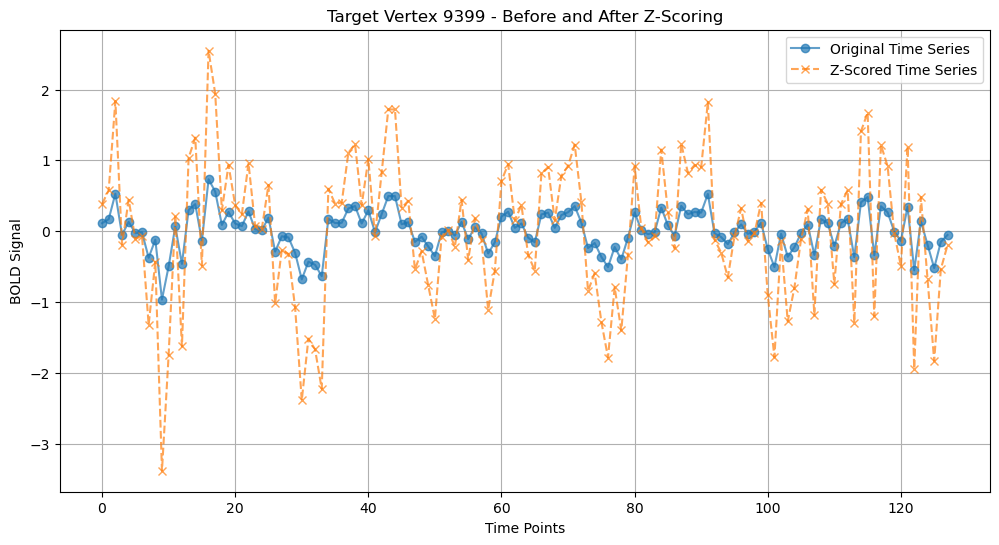

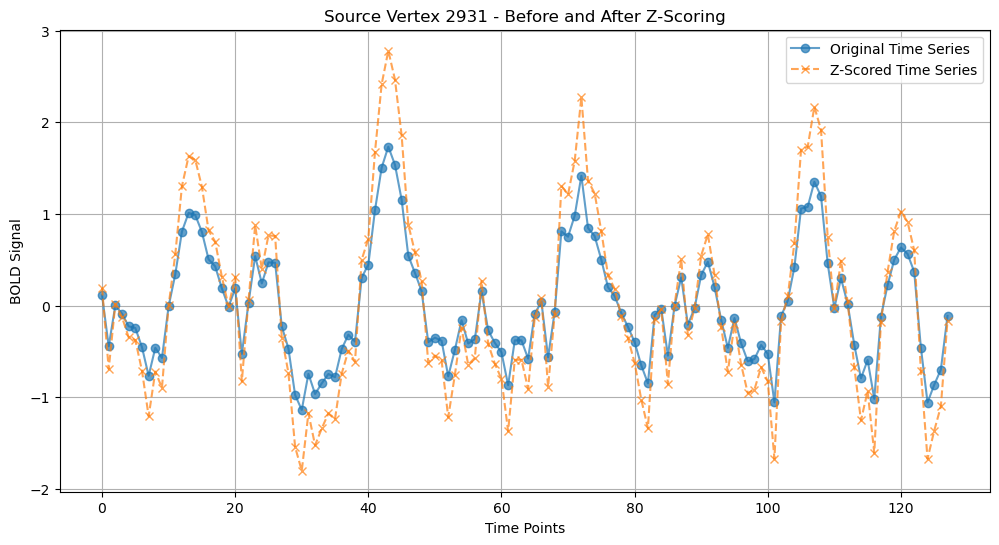

Randomly Selected Target Vertex: Index = 1550, Coordinates = (-18.549, -90.522, 21.367)
Randomly Selected Source Vertex: Index = 109180, Coordinates = (-6.288, -84.294, -2.405)
Sigma Values for Optimization: [10.339873803050406, 1.9000227287412923, 3.2445364849539318, 7.840877622475954, 4.309973089984184, 4.196798356887446, 9.783526894507018, 1.5014124947002012, 1.6571154327381221, 3.993371593054921, 7.961077694889355, 9.927599581963284, 1.536589200407476, 3.808134917727413, 4.395844734055975, 10.154499471861502, 7.357749840456555, 6.025274006274151, 3.9599284355944855, 6.335633284101644, 5.909071358401907, 5.899555069928825, 6.926773824544894, 5.661220793172679, 8.324902917555697, 0.9310995340709322, 6.177893774455414, 9.156433899467181, 6.823490068295062, 2.4157264007823667, 8.788805962576268, 9.25389544640996, 6.0883517561668, 5.045137822864886, 7.873549204695562, 0.6591908940600272, 7.31137550838725, 0.7769157269176649, 1.8130976000851706, 7.916716111932242, 6.449524982446025, 3.46

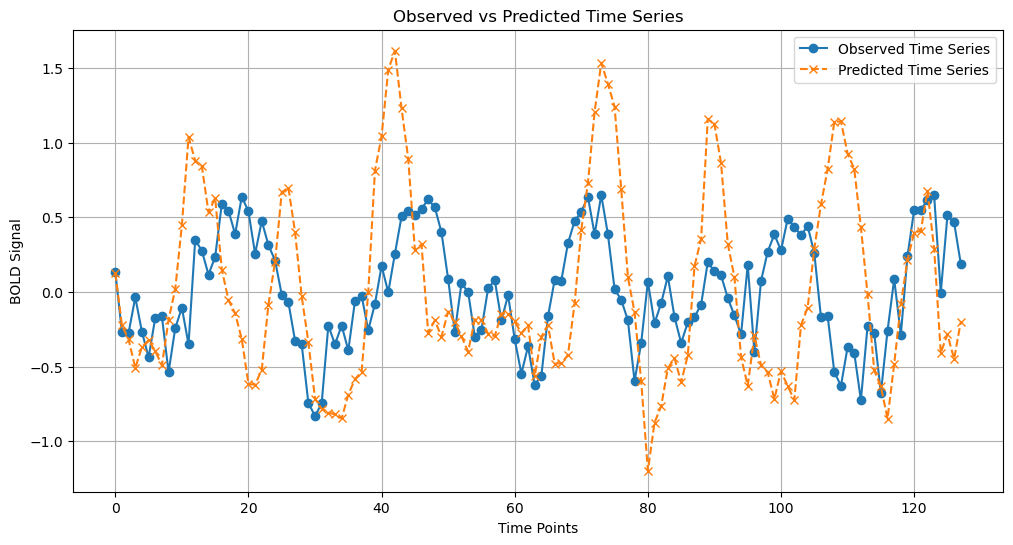

Iterative fit for all target vertices completed in 588.89 minutes.


In [8]:
if __name__ == "__main__":
    # Paths for Federica
    MAIN_PATH = '/Volumes/FedericaCardillo/pre-processing/projects/PROJECT_EGRET-AAA/derivatives'
    CODE_PATH = '/Users/federicacardillo/Documents/GitHub/OBJ_MCMC_CF/OBJ_MCMC_CF'
    
    # Paths for Lloyd
    #MAIN_PATH = r"D:\Documents\School\EGRET-AAA\CFM\data" 
    #CODE_PATH = r"C:\Users\lloyd\Documents\School\EGRET-AAA\Repos\OBJ_MCMC_CF\OBJ_MCMC_CF"
    
    subj = 'sub-46'
    ses = 'ses-02'
    hemi = 'lh'
    delineation = 'manualdelin'
    denoising = 'nordic'
    cutoff_volumes = 8
    target_visual_area = 3
    source_visual_area = 1
    load_one = None  # Set to True if you want to load just one vertex, False to load them all
    # MONTE CARLO MARKOV CHAIN APPROACH
    n_iter = 17500
    TR = 1.5
    rMin = 0.01
    radius = 10.5
    betaBool = True
    burnIn = False
    percBurnIn = 0.10
    proposalWidth = 2.0
    lSigma = 1.0
    lBeta = -5.0
    
    labels_path = f"{MAIN_PATH}/freesurfer/{subj}/label/{hemi}.{delineation}.label"
    time_series_path = f"{MAIN_PATH}/pRFM/{subj}/{ses}/{denoising}/{subj}_{ses}_task-RET_hemi-LR_desc-avg_bold_GM.npy"
    output_dir = f"{CODE_PATH}"
    distance_matrix_path = f"{CODE_PATH}/{subj}_distance_{hemi}_{source_visual_area}.csv"
    output_dir_itertarget = f"{CODE_PATH}/results/{subj}/V{target_visual_area}->V{source_visual_area}" 
    output_dir_itertarget_ONE = f"{CODE_PATH}/results_ONE/{subj}/V{target_visual_area}->V{source_visual_area}" 
    os.makedirs(output_dir_itertarget, exist_ok=True)
    os.makedirs(output_dir_itertarget_ONE, exist_ok=True)
    best_fit_output = f"{output_dir_itertarget}/best_fits.csv"
    individual_output_dir = f"{output_dir_itertarget}/individual_fits"
    plot_dir = f"{output_dir_itertarget}/plots"
    os.makedirs(individual_output_dir, exist_ok=True)
    best_fit_output_ONE = f"{output_dir_itertarget_ONE}/best_fits.csv"
    individual_output_dir_ONE = f"{output_dir_itertarget_ONE}/individual_fits"
    plot_dir_ONE = f"{output_dir_itertarget_ONE}/plots"
    os.makedirs(individual_output_dir_ONE, exist_ok=True)
    os.makedirs(plot_dir_ONE, exist_ok=True)

    # 1. Load Source and Target Vertices 
    idxTarget = Vertex.load_vertices(labels_path, target_visual_area, load_one)
    idxSource = Vertex.load_vertices(labels_path, source_visual_area, load_one)

    # 2. Load the Distance Matrix
    distances_class = Distances(subject=subj, hemi=hemi, matrix_dir=CODE_PATH, csv_path=distance_matrix_path)
    distance_matrix = distances_class.geodesic_dists(hemi=hemi, subject=subj, vertices=idxSource, source=source_visual_area, output_dir=CODE_PATH)
    distance_matrix = pd.read_csv(distance_matrix_path, index_col=0) # Ensure distance_matrix is loaded as a Pandas DataFrame with proper indexing
    distance_matrix.index = distance_matrix.index.astype(int)  # Convert index to integers
    distance_matrix.columns = distance_matrix.columns.astype(int)  # Convert columns to integers

    # 3. Load Time Series Data
    target_time_course = TimeCourse(time_course_file=time_series_path, vertices=idxTarget, cutoff_volumes=cutoff_volumes)
    source_time_course = TimeCourse(time_course_file=time_series_path, vertices=idxSource, cutoff_volumes=cutoff_volumes)

    # Z-Score Time Series (no z score, mean squared error, later beta estimation)
    z_scored_target = target_time_course.z_score() 
    z_scored_source = source_time_course.z_score()
    target_time_course.plot_comparison(z_scored_data = z_scored_target, vertex_index = idxTarget[0].index, title_prefix = "Target") # Plot the comparison for the same vertex (original vs. z-scored)
    source_time_course.plot_comparison(z_scored_data = z_scored_source, vertex_index = idxSource[0].index, title_prefix = "Source") # Plot the comparison for the same vertex (original vs. z-scored)
    
    # 4. Select a Fixed Target Vertex (V3) and a Random Center Vertex (V1)
    # Randomly: 
    connective_field = ConnectiveField(center_vertex=None, vertex=None)  # Initialize with placeholders
    target_vertex = connective_field.select_target_vertex(idxTarget) # Select Target Vertex
    center_vertex = connective_field.select_source_vertex(idxSource) # Select Center Vertex
    # Not randomly: 
    # target_vertex = connective_field.select_target_vertex(idxTarget, index=0)  # Select the first vertex
    # center_vertex = connective_field.select_source_vertex(idxSource, index=15)  # Select the 10th vertex

    # 5. Create the ConnectiveField Class based on those voxels 
    connective_field = ConnectiveField(center_vertex=center_vertex, vertex=target_vertex)

    # 6. Define Sigma Range for Optimization# Define Range of Sizes
    sigma_values = connective_field.define_size_range(start=0.01, stop=10.5, num=50) 
    
    # 7. Extract the Time Courses
    # Dictionary where the keys are the vertex indices and the values are their corresponding time series arrays.
    source_time_series = {v.index: source_time_course.tSeries[v.index] for v in idxSource} 
    target_time_series = {v.index: target_time_course.tSeries[v.index] for v in idxTarget} 
    observed = target_time_course.tSeries[target_vertex.index] # Extracts the time series for the target vertex in V3 (target area).
    
    # 8. Run Optimization
    connective_field.optimize_parameters(observed = observed, source_time_series = source_time_series, distance_matrix = distance_matrix, sigma_values = sigma_values)
    
    # 10. Plot the Observed vs. Predicted Time Series
    connective_field.observed_time_series = observed
    connective_field.plot_time_series()
    
    # Run the iterative fit for all target vertices
    start_time = time.time()
    connective_field = ConnectiveField(center_vertex=None, vertex=None)  # Initialize with placeholders

    # Iterate through one vertex 
    target_vertex = idxTarget[0]
    connective_field.iterative_fit_target(
        target_vertex=target_vertex,
        target_time_course=target_time_course,
        source_vertices=idxSource,
        source_time_series=source_time_series,
        distance_matrix=distance_matrix,
        sigma_values=sigma_values,
        best_fit_output=best_fit_output_ONE,
        individual_output_dir=individual_output_dir_ONE,
        plot_dir=plot_dir_ONE)
    
    # Iterate through all target vertices
    for target_vertex in idxTarget:
       connective_field.iterative_fit_target(
            target_vertex=target_vertex,
            target_time_course=target_time_course,
            source_vertices=idxSource,
            source_time_series=source_time_series,
            distance_matrix=distance_matrix,
            sigma_values=sigma_values,
            best_fit_output=best_fit_output,
            individual_output_dir=individual_output_dir, plot_dir=plot_dir)
        
    elapsed_time = (time.time() - start_time) / 60 ## 97 minutes 
    print(f"Iterative fit for all target vertices completed in {elapsed_time:.2f} minutes.")  # 391.92 sub-36, 500.00 sub-46 

    """ MONTE CARLO MARKOV CHAIN IMPLEMENTATION: under development
    # SOLVING SOME ERRORS TO RUN THE MCMC
    # n_voxels = self.tSeriesTarget.shape[1] --> AttributeError: 'dict' object has no attribute 'shape'
    # Convert the time series dictionary into a NumPy array
    target_time_series = np.array(list(target_time_series.values())) ## SOLVED
    source_time_series = np.array(list(source_time_series.values())) ## SOLVED
    distance_matrix_np = distance_matrix.values
    mcmc_model = MCMC(idxSource=idxSource, distances=distance_matrix_np,
        tSeriesSource=source_time_series, tSeriesTarget=target_time_series,
        n_iter=n_iter, TR=TR, rMin=rMin, radius=radius, betaBool=betaBool, burnIn=burnIn,
        percBurnIn=percBurnIn, proposalWid1th=proposalWidth, lSigma=lSigma, lBeta=lBeta)

    # Run MCMC
    best_fit = mcmc_model.run_mcmc() """

In [9]:
import cortex 
from dag_prf_utils.pycortex import *
MAIN_PATH = '/Volumes/FedericaCardillo/pre-processing/projects/PROJECT_EGRET-AAA/derivatives'
sub = 'sub-34'
fs_dir = f"{MAIN_PATH}/freesurfer"
pm = PyctxMaker(
    sub=sub,
    fs_dir=fs_dir, 
)

# pm.quick_show()
from dag_prf_utils.utils import dag_load_roi
# !pip install libigl
v3_idx = dag_load_roi(fs_dir=fs_dir, sub=sub, roi='V3')
# pm.make_flat_map(
#     centre_bool=v1_idx,
#     method='igl', # 'igl' or 'latlon'
#     hemi_project='inflated', # Starting point for flattening (e.g., inflated, pial, sphere)
#     morph=20, # Can expand or shrink the selection on the mesh (dilation/erosion)
#     # flat_name='v1_iglB',
#     # cut_box=True, 
# )

no dash..
Using fs dir = /Volumes/FedericaCardillo/pre-processing/projects/PROJECT_EGRET-AAA/derivatives/freesurfer
/Volumes/FedericaCardillo/pre-processing/projects/PROJECT_EGRET-AAA/derivatives/pycortex
default
/Volumes/FedericaCardillo/pre-processing/projects/PROJECT_EGRET-AAA/derivatives/pycortex/sub-34
Multiple matches for V3 in /Volumes/FedericaCardillo/pre-processing/projects/PROJECT_EGRET-AAA/derivatives/freesurfer/sub-34/label
['lh.V3_manual.label', 'lh.V3manual.label', 'lh.manualV3edit.label']


ValueError: 

In [ ]:
x = np.hstack(
    [
        pm.mesh_info['sphere']['lh']['coords'][:,0],
        pm.mesh_info['sphere']['rh']['coords'][:,0]
    ]) 
pm.flat_mpl(
    data=x, cmap='RdBu', vmin=-np.pi, vmax=np.pi,
    data_mask=v3_idx,
    flat_name='flat',
    )

In [ ]:
center_vertex = connective_field.select_source_vertex(idxSource, index=15) 
# distances_class.geodesic_dists('lh', sub, 0)
eg_field = connective_field.calculate_gaussian_weights(
    distances=distance_matrix.iloc[:,0],
    sigma = 20
)
eg_field
full_field = np.zeros(pm.total_n_vx)
full_field[np.where(v1_idx)[0][:1394]] = distance_matrix.iloc[50,:].values
pm.flat_mpl(data=full_field, data_mask=v1_idx)

In [ ]:
prf_info = f"{output_dir_itertarget}/best_fits_with_prf.csv"
prfs = np.load(prf_info, allow_pickle=True)
prfs

In [ ]:
pm.quick_show()

In [ ]:
### def quick_grid_fit (no beta alternative)

### Vicarious_somatotopy